In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from tqdm.notebook import tqdm

In [2]:
patents = pd.read_csv('data/merged.csv')

# Add column "Section" with first letter of "IPC"
patents['Section'] = patents['IPC'].str[0]
patents = patents.dropna()
patents = patents[patents['Section'] != 'I']
patents

,Text,Year,IPC,Section
0,Automatic system for teaching and monitoring l...,1992,G09B-007/06,G
1,Automatic system for teaching and monitoring l...,1992,G09B-005/06,G
2,Automatic system for teaching and monitoring l...,1992,G09B-005/02,G
3,Automatic system for teaching and monitoring l...,1992,G09B-005/12,G
4,Automatic system for teaching and monitoring l...,1992,G06F-000/00,G
...,...,...,...,...
2727799,System for generating examination of spelling ...,2016,G06F-017/21,G
2727800,System for generating examination of spelling ...,2016,G06K-019/06,G
2727801,System for generating examination of spelling ...,2016,G06F-017/30,G
2727802,System for providing advertisement keyword in ...,2016,G06Q-030/02,G


In [3]:
sections = patents['Section'].unique()
sections.sort()
sections

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], dtype=object)

In [4]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1, 1),
        lowercase=True,
        stop_words='english',
    )),
    # ('pca', PCA(n_components=0.95)),
    ('clf', LogisticRegression(
        solver='newton-cg',
        multi_class='ovr',
        n_jobs=-1,
        class_weight='balanced'
    ))
])

In [23]:
sample_count = 100000

data = {}

pbar = tqdm(range(2000, 2018))
for i, year in enumerate(pbar):
    before_year = patents[patents['Year'] < year]
    before_year_count = before_year.shape[0]
    before_year = before_year.sample(min(sample_count, before_year_count*(i+2)))
    pbar.set_description(f'Fitting {year}')
    pipeline.fit(before_year['Text'], before_year['Section'])

    data[year] = {}
    pbar2 = tqdm(range(2000, 2018))
    for test_year in pbar2:
        pbar2.set_description(f'Predicting {test_year}')
        data[year][test_year] = {}
        in_year = patents[patents['Year'] == test_year]
        in_year_count = in_year.shape[0]
        in_year = in_year.sample(min(sample_count, in_year_count))

        pbar.set_description(f'Predicting {year} {test_year}')
        y_pred = pipeline.predict(in_year['Text'])
        data[year][test_year]['y_true'] = in_year['Section']
        data[year][test_year]['y_pred'] = y_pred

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

In [24]:
# save data
import pickle
with open('data/data.pickle', 'wb') as f:
    pickle.dump(data, f)

In [20]:
# read data
with open('data/data.pickle', 'rb') as f:
    data = pickle.load(f)

In [34]:
data

{2000: {2000: {'y_true': 396308    G
   328728    G
   307195    G
   358410    G
   264223    G
            ..
   329474    G
   317872    C
   426595    G
   403640    A
   448048    G
   Name: Section, Length: 100000, dtype: object,
   'y_pred': array(['B', 'F', 'G', ..., 'G', 'G', 'B'], dtype=object)},
  2001: {'y_true': 528722    G
   596208    G
   577106    G
   565335    A
   521167    G
            ..
   317024    G
   488121    G
   556011    G
   480787    H
   597193    G
   Name: Section, Length: 100000, dtype: object,
   'y_pred': array(['G', 'G', 'G', ..., 'A', 'B', 'G'], dtype=object)},
  2002: {'y_true': 491418    G
   636656    A
   756665    G
   752188    A
   656963    H
            ..
   716275    B
   619260    G
   715793    H
   659733    G
   634564    F
   Name: Section, Length: 100000, dtype: object,
   'y_pred': array(['A', 'H', 'G', ..., 'E', 'G', 'G'], dtype=object)},
  2003: {'y_true': 637101    G
   903663    H
   887497    G
   721974    G
   814911   

In [37]:
yrs = []
ress = []

for year, res in data[2000].items():
    yrs.append(year)
    ress.append(classification_report(res['y_true'], res['y_pred'], output_dict=True))

In [29]:
# plot f1-score for each section by year in one plot
d = {}
for section in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
    d[section] = []
    for res in ress:
        d[section].append(res[section]['f1-score'])

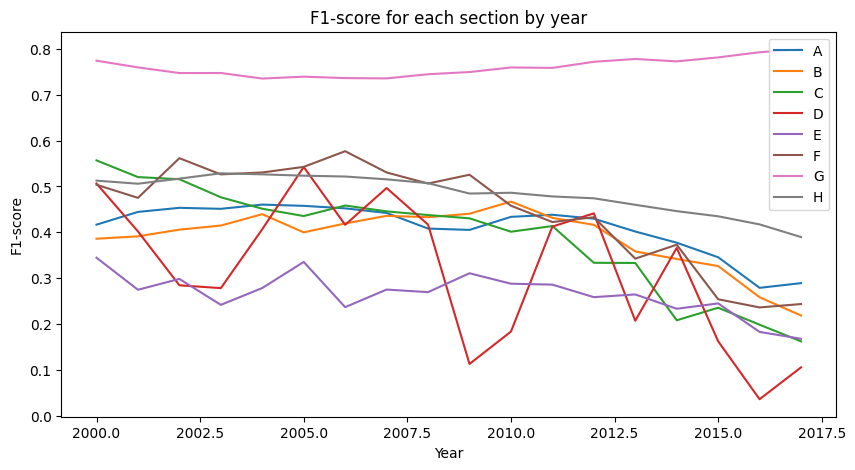

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
for section in sections:
    ax.plot(yrs, d[section], label=section)
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('F1-score')
ax.set_title('F1-score for each section by year')
plt.show()

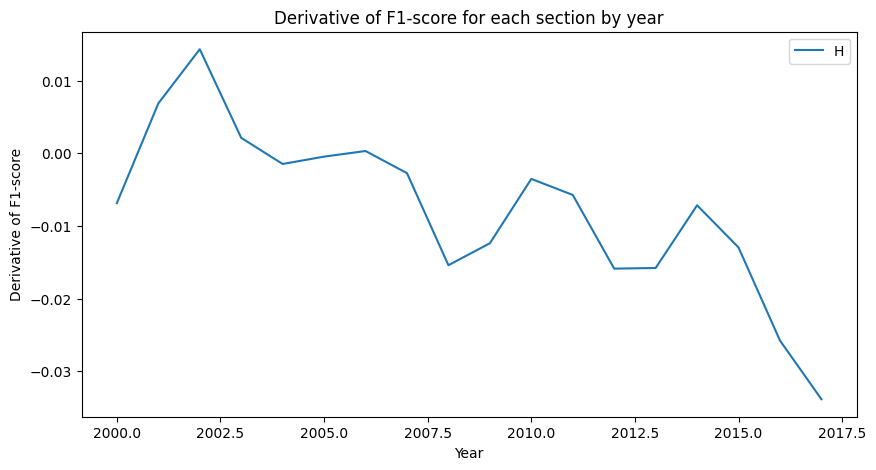

In [40]:
# plot derivative of f1-score for each section by year in one plot
d = {}
sections = ['H']
for section in sections:
    d[section] = []
    for res in ress:
        d[section].append(res[section]['f1-score'])

fig, ax = plt.subplots(figsize=(10, 5))
for section in sections:
    ax.plot(yrs, np.gradient(d[section]), label=section)
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Derivative of F1-score')
ax.set_title('Derivative of F1-score for each section by year')
plt.show()

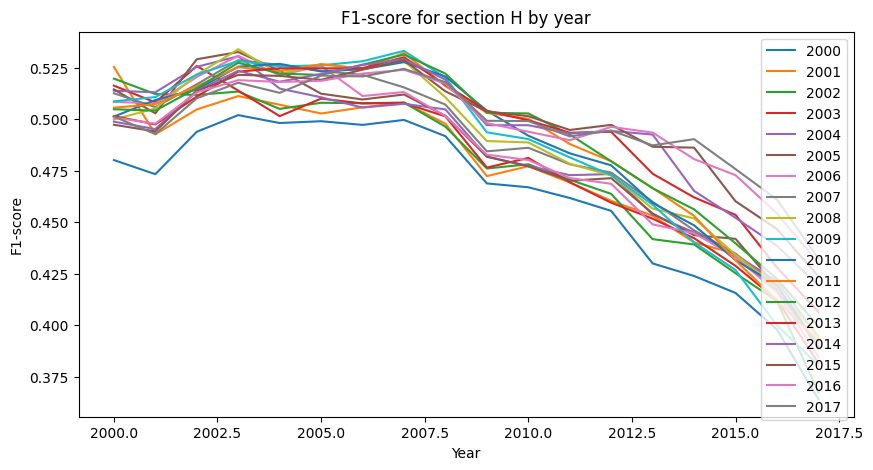

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))

for classifier_year, d in data.items():
    scores = []
    years = []
    for test_year, d2 in d.items():
        years.append(test_year)
        scores.append(classification_report(d2['y_true'], d2['y_pred'], output_dict=True)['H']['f1-score'])
    ax.plot(years, scores, label=classifier_year)

ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('F1-score')
ax.set_title('F1-score for section H by year')
plt.show()